In [24]:
import pandas as pd
import numpy as np
import os

In [2]:
# competencies = pd.read_csv("competencies.csv")
# competencies = competencies.dropna()[['Id', 'Интересы']]
# social = pd.read_excel("social.xlsx", names=['id', 'name', 'fb', 'ok', 'vk', 'email', 'twitter'])
# accepted = social.fb.dropna().index | social.vk.dropna().index
# social = social.loc[accepted, ['name', 'id', 'vk', 'fb']]
# social.vk = social.vk.apply(lambda x: str(x).split("/")[-1])
# social.fb = social.fb.apply(lambda x: str(x).split("/")[-1])
# social.fb = social.fb.apply(lambda x: str(x).split("id=")[-1])
# social.fb = social.fb.apply(lambda x: str(x).split("?ref=")[0])
# social.fb = social.fb.replace('nan', np.nan)
# social = social.merge(df[['vk', 'vk_id']], how='outer', on='vk')
# social.vk = social.vk_id.fillna(0)
# social = social.replace(0, np.nan).drop(labels=['vk_id'], axis=1)
# social.set_index('id', inplace=True)
# social = social.merge(how='inner', right=competencies, left_index=True, right_on='Id').drop("Id", axis=1)
# social.to_msgpack("assets/social.msg")

# def get_id(screen_name):
#     try:
#         item = vk.users.get(user_ids=screen_name)
#         if 'deactivated' not in item:
#             return item[0]['id']
#     except Exception as e:
#         print(e.args)
# Нужно замапить screen_name с их vk_id, поэтому придется обрабатывать по одному

social = pd.read_msgpack("social.msg")

In [25]:
social = pd.DataFrame([a.split() for a in """Ольга Аврясова https://www.facebook.com/olga.avryasova?fref=ts
Василий Быков https://www.facebook.com/vb77box?fref=ts
Павел Подлипский https://www.facebook.com/profile.php?id=100001490423411
Владимир Лебединский https://www.facebook.com/vlebedinskiy?fref=ts""".split("\n")], columns=["Ф", "И", "link"])

In [26]:
social['ФИ'] = social['Ф'] + " " + social['И']

In [27]:
social = social[['ФИ', 'link']]

In [28]:
social = social.set_index('ФИ')

In [29]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys


In [30]:
def parse_link_fb(driver, link):
    if driver.current_url != link:
        driver.get(link)
    n = 0
    lh = 0
    MAX = 30

    while n < MAX:
        print('\t{0}%'.format(round(100*n/MAX)))
        n += 1
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)

        q = driver.find_element_by_tag_name('body').size['height']
        if lh == q:
            break
        lh = q

    for i in driver.find_elements_by_xpath('//a[@class="see_more_link"]'):
        try:
            i.click()
        except BaseException: pass

    q = driver.find_elements_by_xpath('//p')
    result = [i.text for i in q]
    return result

In [31]:
driver = webdriver.Chrome("../chromedriver")

In [45]:
import time
t = {}
# At this time you need to authorize into Facebook in appeared Chrome window
# time.sleep(30)
for name, link in social.iterrows():
    link = link['link']
    t[name] = parse_link_fb(driver, link)

	0%
	3%
	0%
	3%
	7%
	10%
	13%
	17%
	20%
	23%
	27%
	30%
	33%
	37%
	40%
	43%
	47%
	50%
	53%
	57%
	60%
	63%
	67%
	70%
	73%
	77%
	80%
	83%
	87%
	90%
	93%
	97%
	0%
	3%
	7%
	10%
	13%
	17%
	20%
	23%
	27%
	30%
	33%
	37%
	40%
	43%
	47%
	50%
	53%
	57%
	60%
	63%
	67%
	70%
	73%
	77%
	80%
	83%
	87%
	90%
	93%
	97%
	0%
	3%
	7%
	10%
	13%
	17%
	20%
	23%
	27%
	30%
	33%
	37%
	40%
	43%
	47%
	50%
	53%
	57%
	60%
	63%
	67%
	70%
	73%
	77%
	80%
	83%
	87%
	90%
	93%
	97%


In [46]:
import json
json.dump(t, open("t_0111.json", "w"))

In [47]:
import itertools
import pymorphy2
import re
import os
import pandas as pd
import time
from nltk.tokenize import RegexpTokenizer

import pickle
import json
import numpy as np
from sklearn.preprocessing import normalize
from keras.models import load_model

from functools import lru_cache
import tqdm
class CorporaClass:
    """Class for setting up corpora"""

    def __init__(self):
        self.corpora = []
        self.vocab = set()
        self.labels = []

    tokenizer = RegexpTokenizer('\w+')
    morph = pymorphy2.MorphAnalyzer()
    ru_pattern = re.compile("[а-яА-Я]")

    @staticmethod
    @lru_cache(maxsize=100000)
    def full_process(text, tokenizer=tokenizer, morph=morph, ru_pattern=ru_pattern):
        # Clear text from punctuation etc.'''
        tokens = tokenizer.tokenize(text)

        # Turn tokens into normal form excluding non-nouns or verbs
        processed = []
        for token in tokens:
            morphed = morph.parse(token)[0].normal_form
            nf_tag = str(morph.parse(morphed)[0].tag.POS)
            if nf_tag in ("NOUN", "ADJF", "INFN", "NUMR") and len(token) < 16:
                if len(morphed) == len(re.findall(ru_pattern, morphed)):
                    processed.append(morphed)

        return processed

    def add_to_corpora(self, file_object, label):
        doc = []
        for line in file_object:
            try:
                processed = line
            except Exception as e:
                print(e)
                processed = ""
            if len(processed.split()) > 2:
                doc.append(processed)
        if len(doc) > 2:
            self.corpora.append(doc)
            self.labels.append(label)

categories = ['art', 'politics', 'finances', 'strateg_management', 'law', 'elaboration', 'industry',
                   'education', 'charity', 'public_health', 'agriculture', 'government_management', 'smm',
                   'innovations', 'safety', 'military', 'corporative_management', 'social_safety', 'building',
                   'entrepreneurship', 'sport', 'investitions']
path = "/Users/thepowerfuldeez/Dropbox/Projects/vk_text_classifier/assets/vk_texts_classifier.h5"
classifier = load_model(path)
path = "/Users/thepowerfuldeez/Dropbox/Projects/vk_text_classifier/assets/vectorizer.p"
vectorizer = pickle.load(open(path, "rb"))

In [48]:
def get_result(texts):
    corpora_class = CorporaClass()
    corpora_class.add_to_corpora(texts, '')
    print("Added to corpora")
    try:
        transformed = vectorizer.transform(corpora_class.corpora[0])
        print("Transformed corpora.")
        predicted = classifier.predict(transformed.toarray())
        verdict = normalize(np.sum(predicted, axis=0).reshape(1, -1))[0]
        return list(zip(categories, verdict))
    except:
        return list(zip(categories, np.zeros(len(categories))))
    

In [49]:
import json
t = json.load(open("t_0111.json"))

In [50]:
cols = ["ФИ"] + categories
result = pd.DataFrame(columns=cols)

In [51]:
a = []
for name, texts in t.items():
    l = [name] + [b for a, b in get_result(texts)]
    a.append(l)

Added to corpora
Added to corpora
Transformed corpora.
Added to corpora
Transformed corpora.
Added to corpora
Transformed corpora.


In [52]:
result = pd.DataFrame(a, columns=cols)

In [53]:
result.to_csv("result_0111.csv")

In [66]:
import time
MAX = 30
lh = 0
# At this time you need to authorize into Facebook in appeared Chrome window
time.sleep(30)

# TODO: Replace files with new Redis
for pg, user in enumerate(social.fb):
    path = f"assets/corpora_cached_fb_users/{user}.txt"
    if not os.path.exists(path):
        print('[{0}]: {1}%'.format(user, round(100*pg/len(social.fb))))
        z = "https://www.facebook.com/" + user
        if driver.current_url != z:
            driver.get(z)
        n = 0

        while n < MAX:
            print('\t{0}%'.format(round(100*n/MAX)))
            n += 1
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(2)

            q = driver.find_element_by_tag_name('body').size['height']
            if lh == q:
                break

            lh = q

        for i in driver.find_elements_by_xpath('//a[@class="see_more_link"]'):
            try:
                i.click()
            except BaseException: pass

        q = driver.find_elements_by_xpath('//p')
    #     text[user] = []
        with open(path, "w") as f:
            for i in q:
                _ = f.write(i.text)


[maria.morozova.479]: 66%
	0%
	3%
	7%
	10%
	13%
	17%
	20%
	23%
	27%
	30%
	33%
	37%
	40%
	43%
	47%
	50%
[kamal.daudov]: 67%
	0%
	3%
	7%
	10%
	13%
	17%
	20%
	23%
	27%
	30%
[khomyakov.yuri?fref=ts]: 67%
	0%
	3%
[100004412764109]: 67%
	0%
	3%
	7%
	10%
	13%
	17%
[sergey kruchinkin]: 67%
	0%
	3%
[100010615158719]: 67%
	0%
	3%
	7%
	10%
	13%
	17%
	20%
	23%
	27%
	30%
	33%
	37%
	40%
	43%
	47%
	50%
	53%
	57%
	60%
	63%
	67%
	70%
	73%
	77%
	80%
	83%
	87%
	90%
	93%
	97%
[al3ru]: 67%
	0%
	3%
	7%
	10%
	13%
	17%
	20%
	23%
	27%
	30%
	33%
	37%
	40%
	43%
	47%
	50%
	53%
	57%
	60%
	63%
	67%
	70%
	73%
	77%
	80%
	83%
	87%
	90%
	93%
[ANMetelkin]: 67%
	0%
	3%
	7%
	10%
	13%
	17%
	20%
	23%
	27%
	30%
	33%
	37%
	40%
	43%
	47%
	50%
	53%
	57%
	60%
	63%
	67%
	70%
	73%
	77%
	80%
	83%
	87%
	90%
	93%
	97%
[sveshnikov.ivan]: 67%
	0%
	3%
	7%
	10%
	13%
	17%
	20%
	23%
	27%
	30%
	33%
	37%
	40%
	43%
[100001720970510]: 67%
	0%
	3%
	7%
	10%
	13%
[nikonorova.ev@gmail.com]: 67%
	0%
	3%
[shikate]: 67%
	0%
	3%
	7%
	10%
	13%
	17%
	20

TypeError: must be str, not float

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import numpy as np

In [62]:
values = [0.0, 0.00020327999999999999, 0.00079889000000000002, 0.0017945700000000001, 0.0031978900000000001, 0.0049998600000000001, 0.0071999500000000001, 0.0097946600000000002, 0.01279538, 0.01619427, 0.01999888, 0.024198799999999999, 0.028797300000000001, 0.033804220000000003, 0.03920469, 0.044998549999999998, 0.051196110000000003, 0.057786879999999999, 0.064777520000000005, 0.072173360000000006, 0.079974939999999994, 0.088165880000000002, 0.096761089999999994, 0.10577214, 0.1151765, 0.12496259, 0.135162, 0.14577203, 0.15676870000000001, 0.16817628000000001, 0.17998386, 0.19218045, 0.20480998, 0.21781874000000001, 0.23122633000000001, 0.24501508999999999, 0.25921522000000002, 0.27381072000000001, 0.28881902999999998, 0.30423603999999999, 0.32006068999999998, 0.33624767, 0.35284788, 0.36984424999999999, 0.38724442999999997, 0.40503294000000001, 0.42325791000000001, 0.44186361000000002, 0.46085747999999999, 0.48026213000000001, 0.50006307999999999, 0.51986668999999996, 0.53925557999999996, 0.55826167999999998, 0.57683446000000005, 0.59501444999999997, 0.61282563000000001, 0.63023797000000004, 0.64722204000000005, 0.66382236999999999, 0.68001602000000005, 0.69579921, 0.71122026000000005, 0.72622180999999997, 0.7408207, 0.75501907999999995, 0.76880990999999999, 0.78219848999999997, 0.79519837000000004, 0.80779615000000005, 0.81998987999999995, 0.83178331999999999, 0.84317829, 0.85419529999999999, 0.86479486000000005, 0.87498916000000004, 0.88479467000000001, 0.89419208999999999, 0.90318049, 0.91178185, 0.91999454000000003, 0.92779310000000004, 0.93519143999999998, 0.94219509999999995, 0.94878748999999996, 0.95499458999999998, 0.96078463000000003, 0.96618519000000003, 0.97118837000000002, 0.97579413000000004, 0.97999437, 0.98380230000000002, 0.98720991000000002, 0.99020830999999998, 0.99280265999999995, 0.99500158000000005, 0.99680073999999996, 0.99820505000000004, 0.99920310000000001, 0.99979954000000004, 1.0]

In [68]:
import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [71]:
sigmoid(0.5)

0.6224593312018546

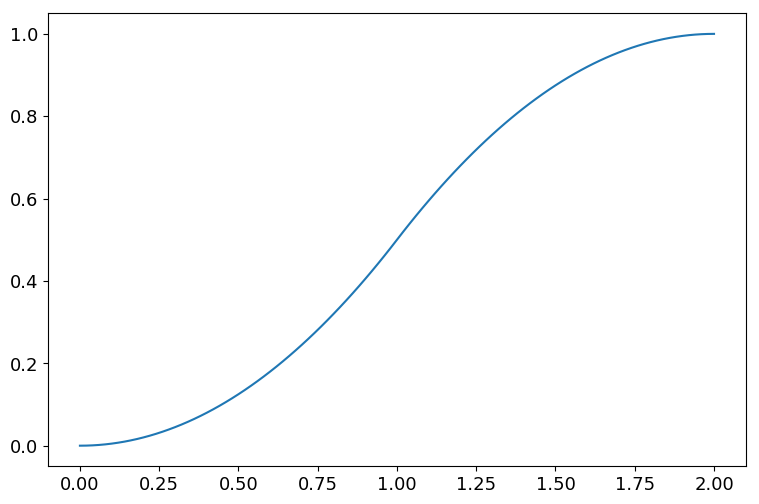

In [63]:
plt.plot(np.arange(0, 2.02, 0.02), values)

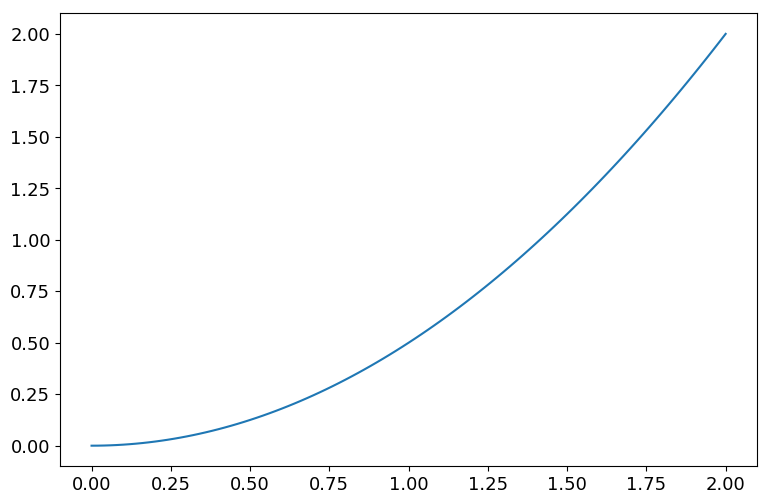

In [107]:
plt.plot(np.arange(0, 2.02, 0.02), np.arange(0, 2.02, 0.02)**2 / 2)